In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4500)])
    except RuntimeError as e:
        print(e)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import tensorflow.keras as keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D
from tensorflow.keras.layers import  Dropout, Activation
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
import tensorflow as tf
import glob
import random
import cv2
from random import shuffle
from PIL import Image, ImageEnhance

In [3]:
# create rle for dataset_1
%run create_rle_for_dataset_1.ipynb

In [4]:
# crop the image into patches of 256x256  and save them
%run crop_image_save.ipynb

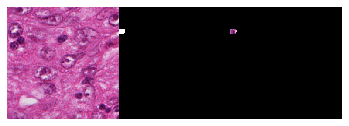

In [5]:
#import data 
%run import_data_256.ipynb

In [6]:
def unet(sz = (256,256, 3)):
    x = Input(sz)
    inputs = x
  
  #down sampling 
    f = 8
    layers = []

    for i in range(0, 6):
        x = Conv2D(f, 3, activation='relu', padding='same') (x)        
        x = Conv2D(f, 3, activation='relu', padding='same') (x)
        layers.append(x)
        x = MaxPooling2D() (x)
        f = f*2
    ff2 = 64 
  
  #bottleneck 
    j = len(layers) - 1
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
    x = Concatenate(axis=3)([x, layers[j]])
    j = j -1 
  
  #upsampling 
    for i in range(0, 5):
        ff2 = ff2//2
        f = f // 2 
        x = Conv2D(f, 3, activation='relu', padding='same') (x)
        x = Conv2D(f, 3, activation='relu', padding='same') (x)
        x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
        x = Concatenate(axis=3)([x, layers[j]])
        j = j -1 
    
  
  #classification 
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    outputs = Conv2D(1, 1, activation='sigmoid') (x)
  
  #model creation 
    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model

In [7]:
model=unet()

In [8]:
model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
train_steps = len(train_files) //batch_size
test_steps = len(test_files) //batch_size
history=model.fit(train_generator, 
                    epochs = 50, steps_per_epoch = train_steps,validation_data = test_generator, validation_steps = test_steps, verbose = 1)


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 443 steps, validate for 24 steps
Epoch 1/50
443/443 [==============================] - 26s 59ms/step - loss: 0.1734 - accuracy: 0.9870 - val_loss: 0.0438 - val_accuracy: 0.9924
Epoch 2/50
443/443 [==============================] - 21s 47ms/step - loss: 0.0502 - accuracy: 0.9909 - val_loss: 0.0438 - val_accuracy: 0.9919
Epoch 3/50
443/443 [==============================] - 21s 47ms/step - loss: 0.0473 - accuracy: 0.9910 - val_loss: 0.0501 - val_accuracy: 0.9895
Epoch 4/50
443/443 [==============================] - 21s 47ms/step - loss: 0.0474 - accuracy: 0.9906 - val_loss: 0.0470 - val_accuracy: 0.9909
Epoch 5/50
443/443 [==============================] - 21s 47ms/step - loss: 0.0471 - accuracy: 0.9909 - val_loss: 0.0389 - val_accuracy: 0.9917
Epoch 6/50
443/443 [==============================] - 21s 47ms/step - loss: 0.0451 - accuracy: 0.9912 - val_loss: 0.0454 - val_accuracy: 0.9912
Epoch 7/50
443/443 [=======================

In [9]:
#loading dataset_2

In [10]:
import tifffile

In [11]:
t=tifffile.imread('dataset_2/A03_00Aa.tiff')
i=Image.fromarray(t)
i=i.resize((1536,1280))
i=np.array(i)


In [12]:
#crop the dataset2 image into patches of 256x256  and save them

In [13]:
x=0
xplus=256
y=0
yplus=256
file_name=0
for q in range(6):
    for s in range(5):
        tempy=i[x:xplus,y:yplus]
        plt.imsave(f'temp/{str(q)+str(s)}.bmp',tempy)
        
        
        file_name+=1
        x+=256
        xplus+=256

    x=0
    xplus=256
    y+=256
    yplus+=256


In [14]:
import os
all_files = os.listdir('temp/')
all_files.sort()


In [15]:
#predicting rle 

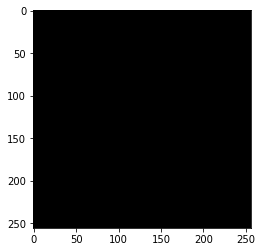

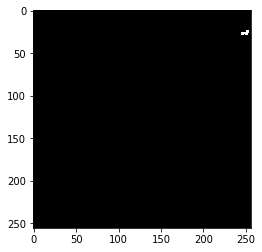

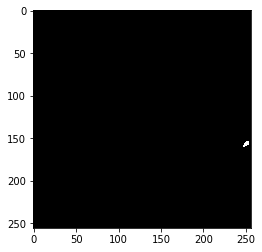

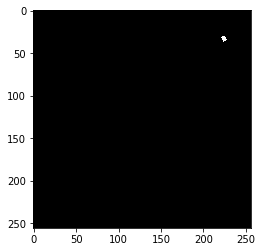

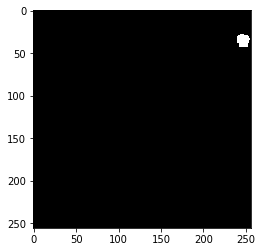

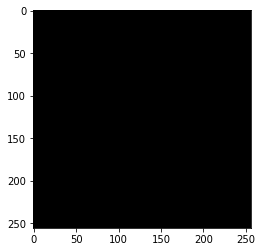

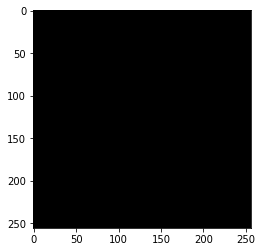

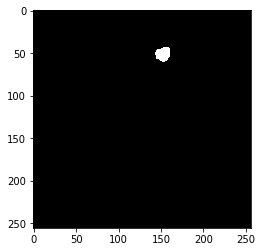

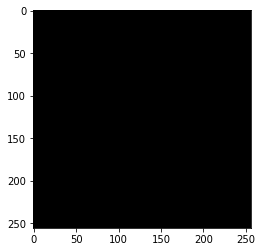

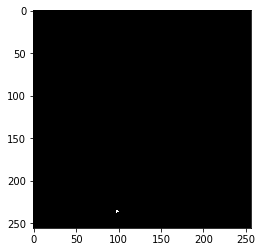

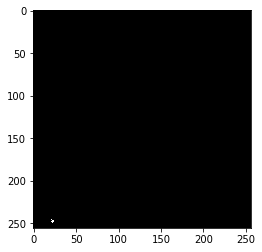

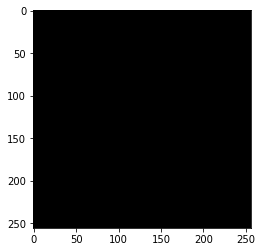

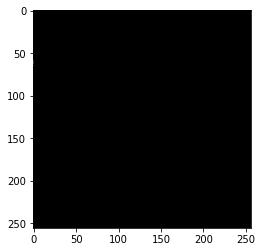

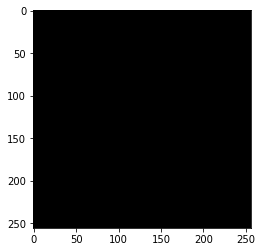

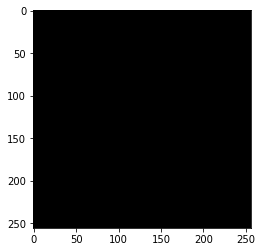

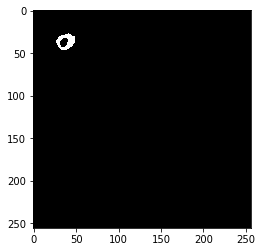

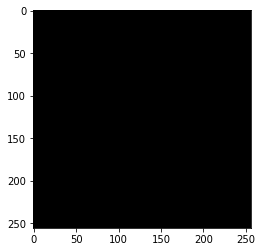

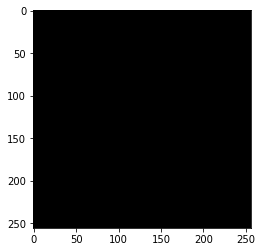

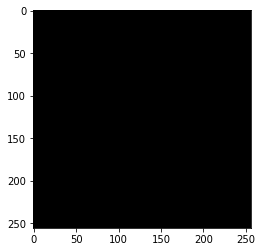

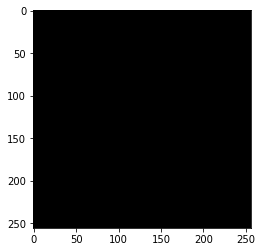

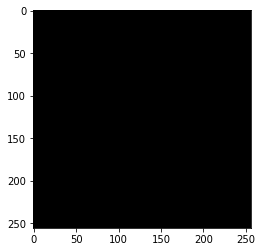

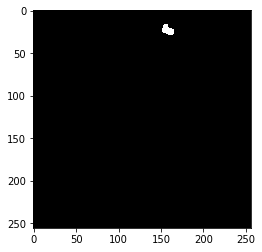

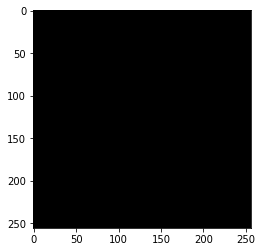

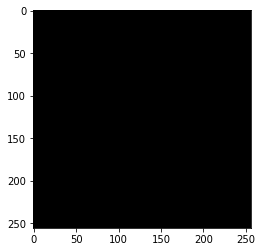

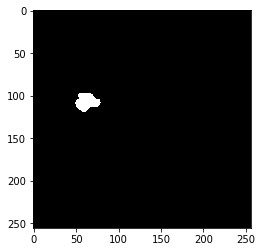

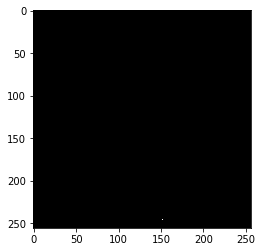

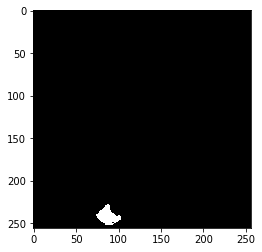

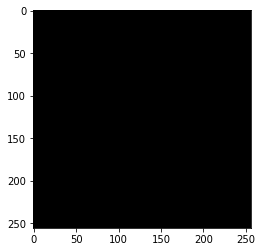

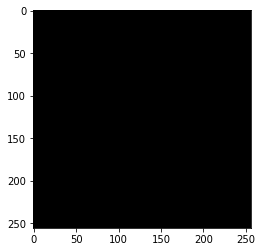

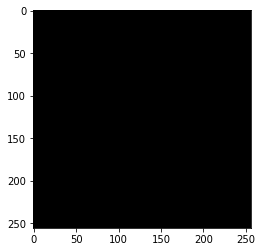

In [16]:
file_count=0
for i in all_files:
    
    raw = Image.open(f'temp/{i}')

    #predict the mask 
    pred = model.predict(np.expand_dims(raw, 0))
    msk  = pred.squeeze()
    msk = np.stack((msk,)*3, axis=-1)
    msk[msk >= 0.5] = 1 
    msk[msk < 0.5] = 0 

    plt.imsave(f'temp_result/{i[:-4]}.bmp',msk)
    file_count+=1
    plt.imshow(msk)
    plt.show()

In [17]:
temparray=np.zeros((1280, 1536, 3),dtype=np.uint8)

In [18]:
#merging rle into one image and saving it into rle_image_dataset_2 folder

In [19]:
x=0
xplus=256
y=0
yplus=256
file_name=0
for q in range(6):
    for s in range(5):

        ttt=plt.imread(f'temp_result/{str(q)+str(s)}.bmp')
        temparray[x:xplus,y:yplus]=ttt
        x+=256
        xplus+=256
    x=0
    xplus=256
    y+=256
    yplus+=256


In [23]:
plt.imsave(f'rle_image_dataset_2/Unet-result.png',temparray)

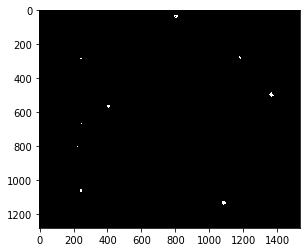

In [21]:
plt.imshow(temparray)